In [3]:
import csv
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import re

@dataclass
class SignalTarget:
    name: str

@dataclass
class MessageSignalTarget:
    name: str

series = {str: {}, float: {}}
defs = {}

num_processed = 0

with open('work/simdb.sqlite.csv', 'rt') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)

    for time_str, target, value in reader:
        if time_str == 'DEF':
            defs[target] = SignalTarget(value)
            continue
        elif time_str == 'DEFM':
            defs[target] = MessageSignalTarget(value)
            continue
        
        time = float(time_str)

        if target in series[str]:
            series[str][target][0].append(time)
            series[str][target][1].append(value)
        elif target in series[float]:
            series[float][target][0].append(time)
            series[float][target][1].append(float(value))
        else:
            try:
                value_float = float(value)
                series[float][target] = ([time], [value_float])
            except:
                series[str][target] = ([time], [value])

        num_processed += 1

print(f'Processed {num_processed} entries for {len(defs)} targets.')

Processed 519 entries for 15 targets.


ScheduleController/0/state:
    0.000: GOTO_NEAREST_STATION
   18.000: BOARDING
   28.000: BOARDING_COMPLETE
   29.000: GOTO_NEAREST_STATION

WaypointController/0/info:
    0.000: Set goal: station CERN Meyrin, 70 m away
    0.000: Planning route to station CERN Meyrin
    0.000: OK route to station CERN Meyrin, distance XXX km
   29.000: Set goal: station Ferney-Voltaire, 5485 m away
   29.000: Planning route to station Ferney-Voltaire
   29.000: OK route to station Ferney-Voltaire, distance XXX km

WaypointController/0/state:
    0.000: EN_ROUTE
   17.000: ARRIVED
   29.000: EN_ROUTE

TractionController/0/state:
    0.000: EN_ROUTE
   16.000: IN_DESTINATION
   17.000: NO_PLAN
   29.000: EN_ROUTE



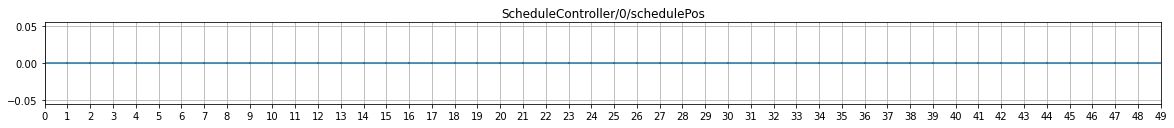

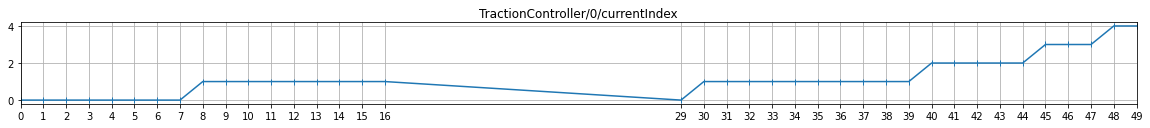

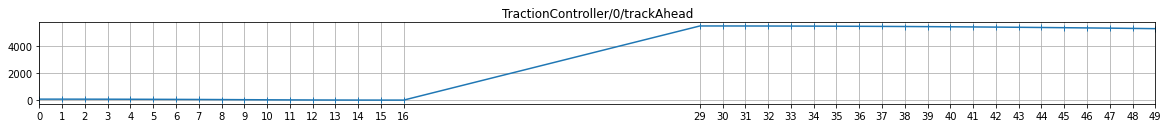

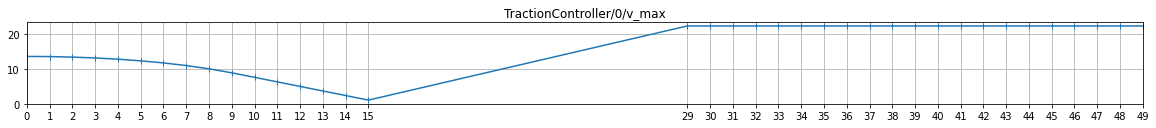

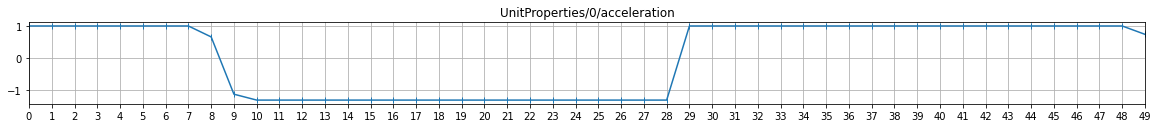

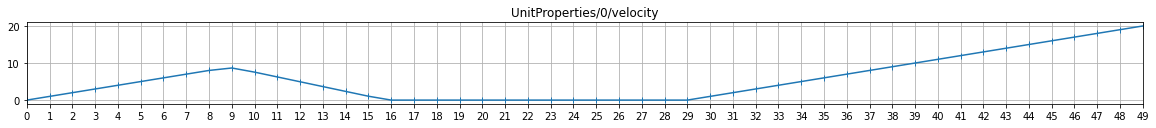

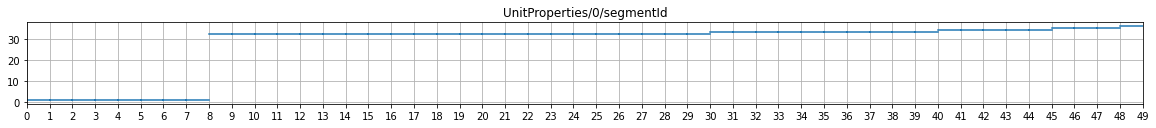

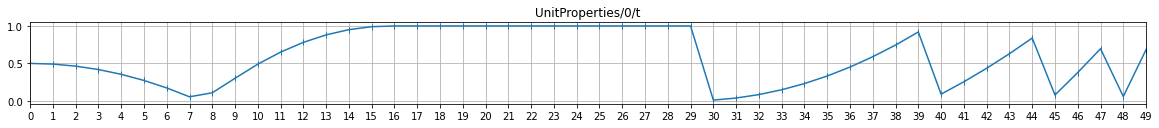

In [4]:
FIG_SIZE = (20,1.5)

for target_id, this_series in series[str].items():
    print(f'{defs[target_id].name}:')
    last_value = None
    for time, value in zip(*this_series):
        if isinstance(defs[target], MessageSignalTarget) or value != last_value:
            print(f'  {time:7.3f}: {value}')
        last_value = value
    print()

xlim = (0, time)
# xlim = (250, 300)

display_options_by_pin_name = {
    'debug': dict(display='none'),
    'segmentId': dict(display='step'),
#     'segmentId': dict(display='none'),
    'schedulePos': dict(display='step'),
}

for target_id, this_series in series[float].items():
    # determine set of display options
    display_options = dict(display='plot')

    tokens = defs[target_id].name.split('/')
    if len(tokens) == 3 and tokens[2] in display_options_by_pin_name:
        display_options = {**display_options, **display_options_by_pin_name[tokens[2]]}

    if display_options['display'] == 'none':
        continue

    # prepare & plot time series
    t, y = this_series[0], this_series[1]

    plt.figure(figsize=FIG_SIZE)
    if display_options['display'] == 'plot':
        plt.plot(t, y, marker="|")
    elif display_options['display'] == 'step':
        # https://stackoverflow.com/a/44961513
        def mystep(x,y, ax=None, **kwargs):
            x = np.array(x)
            y = np.array(y)
            X = np.c_[x[:-1], x[1:], x[1:]]
            Y = np.c_[y[:-1], y[:-1], np.zeros_like(x[:-1]) * np.nan]
            if not ax: ax=plt.gca()
            return ax.plot(X.flatten(), Y.flatten(), **kwargs)

        mystep(t, y)
    plt.title(defs[target_id].name)
    plt.grid(which="both")
    if xlim[1] - xlim[0] < 50:
        plt.xticks(t)

    if xlim is not None: plt.xlim(*xlim)

# reversed_names = dict(map(reversed, names.items()))

# plt.figure(figsize=(20,5))
# target = reversed_names['StationToStationAgent/0/velocity']
# t, y = series[float][target][0], series[float][target][1]
# plt.plot(t, y, label='velocity')
# target = reversed_names['StationToStationAgent/0/velocity(target)']
# t, y = series[float][target][0], series[float][target][1]
# plt.plot(t, y, label='velocity(target)')
# plt.legend()
# plt.grid()